# TuRBO-ENN

This code implements TuRBO [1], a SOTA Bayesian optimization algorithm.

The optimization class, `Turbo`, supports four modes of operation.

**LHD_ONLY**  
Generate a Latin Hypercube Design (LHD) for every batch of arms. This is included as a simple baseline.

**TURBO_ZERO**  
Initialze with LHD. Afterward, sample near the best-so-far x value, x_best. Samples are "near" x_best in two senses: (i) They are in a trust region, an adaptively-sized box around x_best, and (ii) They perturb only a small number of dimensions using RAASP sampling [2]. Other dimensions take the same value as in x_best. The num_arms proposals are chosen randomly from RAASP candidates inside the trust region.

This is included to help differentiate the impact of the trust region from the impact of the surrogate. Notice (below) that the trust region has high impact.

**TURBO_ONE**  
This adds a GP surrogate to TURBO_ZERO. The num_arms proposals are chosen via Thompson sampling from RAASP candidates inside the trust region. Occasionally, the trust region adapter resets and (i) discards all observations, and (ii) begins anew with and LHD design.

This is the standard SOTA method. It should match the TuRBO reference [implementation](https://github.com/uber-research/TuRBO). 

**TURBO_ENN**  
This replaces the GP surrogate with a simpler, more scalable surrogate called Epistemic Nearest Neighbors (ENN). ENN's proposal time scales as $O(N)$ rather than the $O(N^2)$ of a GP surrogate. [3]


## References

1. **Eriksson, D., Pearce, M., Gardner, J. R., Turner, R., & Poloczek, M. (2020).** Scalable Global Optimization via Local Bayesian Optimization. *Advances in Neural Information Processing Systems, 32*.  
   https://arxiv.org/abs/1910.01739

2. **Rashidi, B., Johnstonbaugh, K., & Gao, C. (2024).** Cylindrical Thompson Sampling for High-Dimensional Bayesian Optimization. *Proceedings of The 27th International Conference on Artificial Intelligence and Statistics* (pp. 3502–3510). PMLR.  
   https://proceedings.mlr.press/v238/rashidi24a.html

3. **Sweet, D., & Jadhav, S. A. (2025).** Taking the GP Out of the Loop. *arXiv preprint arXiv:2506.12818*.  
   https://arxiv.org/abs/2506.12818


---

In [1]:
import numpy as np


class Ackley:
    def __init__(self, noise: float, rng):
        self.noise = noise
        self.rng = rng
        self.a = 20.0
        self.b = 0.2
        self.c = 2 * np.pi
        self.bounds = [-32.768, 32.768]

    def __call__(self, x):
        x = np.asarray(x, dtype=float)
        if x.ndim == 1:
            x = x[None, :]
        x = x - 1
        y = (
            -self.a * np.exp(-self.b * np.sqrt((x**2).mean(axis=1)))
            - np.exp(np.cos(self.c * x).mean(axis=1))
            + self.a
            + np.e
        )
        result = -y + self.noise * self.rng.normal(size=(x.shape[0],))
        return result if result.ndim > 0 else float(result)

In [2]:
import time
import torch

from enn import Turbo, TurboMode
from enn.turbo.turbo_config import TurboConfig


def run_optimization(turbo_mode: TurboMode):
    num_dim = 30
    num_iterations = 100
    num_arms = 10
    noise = 0.1
    use_y_hat = False

    rng = np.random.default_rng(17)
    torch.manual_seed(19)
    objective = Ackley(noise=noise, rng=rng)
    bounds = np.array([objective.bounds] * num_dim, dtype=float)

    config = TurboConfig(
        k=10,
        num_fit_samples=100,
        acq_type="ucb",
    )
    optimizer = Turbo(
        bounds=bounds,
        mode=turbo_mode,
        rng=rng,
        config=config,
    )

    best_values = []
    proposal_times = []
    y_hat_best = -np.inf
    y_best = -np.inf

    for iteration in range(num_iterations):
        t_0 = time.time()
        x_arms = optimizer.ask(num_arms=num_arms)
        t_1 = time.time()
        proposal_times.append(t_1 - t_0)

        y_obs = objective(x_arms)

        y_hat = optimizer.tell(x_arms, y_obs, y_var=noise**2 * np.ones_like(y_obs))
        if use_y_hat:
            y_decide = y_hat
        else:
            y_decide = y_obs
        i = np.where(y_decide == np.max(y_decide))[0][0]
        y_hat_batch_best = y_decide[i]

        if y_hat_batch_best > y_hat_best:
            y_hat_best = y_hat_batch_best
            y_best = objective(x_arms[i])[0]

        best_values.append(y_best)
        if iteration % 10 == 0:
            print(
                f"{turbo_mode} iteration = {iteration} y_best = {y_best} y_hat_best = {y_hat_best}"
            )

    evals = num_arms * np.arange(len(best_values))
    return best_values, proposal_times, evals

In [3]:
import matplotlib.pyplot as plt


RUN_TURBO_ONE = False

best_values_zero, proposal_times_zero, evals_zero = run_optimization(
    TurboMode.TURBO_ZERO
)
if RUN_TURBO_ONE:
    best_values_one, proposal_times_one, evals_one = run_optimization(
        TurboMode.TURBO_ONE
    )
best_values_enn, proposal_times_enn, evals_enn = run_optimization(TurboMode.TURBO_ENN)
best_values_lhd, proposal_times_lhd, evals_lhd = run_optimization(TurboMode.LHD_ONLY)

TurboMode.TURBO_ZERO iteration = 0 y_best = -20.975319996048064 y_hat_best = -20.834582450655038
TurboMode.TURBO_ZERO iteration = 10 y_best = -20.372706227165207 y_hat_best = -20.11086343702919
TurboMode.TURBO_ZERO iteration = 20 y_best = -19.374500781158183 y_hat_best = -19.250614440201698
TurboMode.TURBO_ZERO iteration = 30 y_best = -19.403732089255662 y_hat_best = -18.975437426387913
TurboMode.TURBO_ZERO iteration = 40 y_best = -19.403732089255662 y_hat_best = -18.975437426387913
TurboMode.TURBO_ZERO iteration = 50 y_best = -17.547759153771665 y_hat_best = -17.508884240180564
TurboMode.TURBO_ZERO iteration = 60 y_best = -16.086886187034903 y_hat_best = -16.20942382574201
TurboMode.TURBO_ZERO iteration = 70 y_best = -15.05683657786105 y_hat_best = -14.826323373357567
TurboMode.TURBO_ZERO iteration = 80 y_best = -13.615348066976567 y_hat_best = -13.41667262856443
TurboMode.TURBO_ZERO iteration = 90 y_best = -12.119473721116968 y_hat_best = -12.007236117925771
TurboMode.TURBO_ENN itera

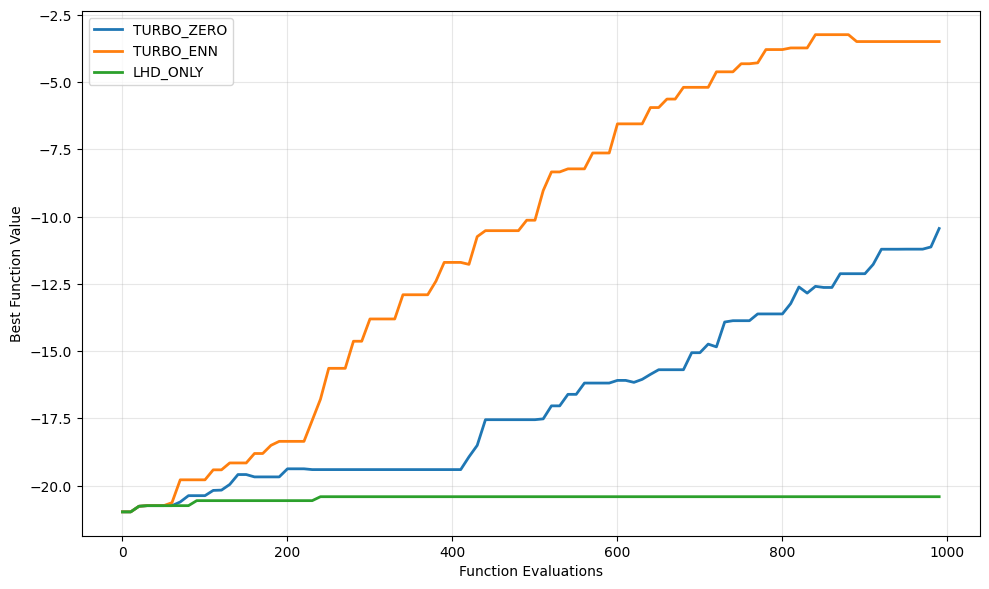

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(evals_zero, best_values_zero, linewidth=2, label="TURBO_ZERO")
plt.plot(evals_enn, best_values_enn, linewidth=2, label="TURBO_ENN")
plt.plot(evals_lhd, best_values_lhd, linewidth=2, label="LHD_ONLY")
if RUN_TURBO_ONE:
    plt.plot(evals_one, best_values_one, linewidth=2, label="TURBO_ONE")
plt.xlabel("Function Evaluations")
plt.ylabel("Best Function Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

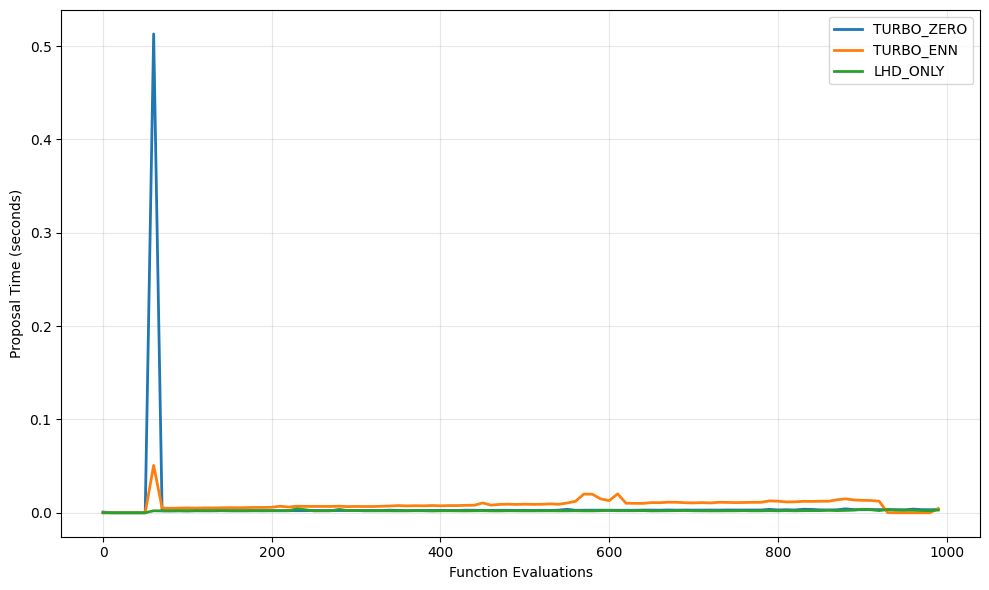

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(evals_zero, proposal_times_zero, linewidth=2, label="TURBO_ZERO")
plt.plot(evals_enn, proposal_times_enn, linewidth=2, label="TURBO_ENN")
plt.plot(evals_lhd, proposal_times_lhd, linewidth=2, label="LHD_ONLY")
if RUN_TURBO_ONE:
    plt.plot(evals_one, proposal_times_one, linewidth=2, label="TURBO_ONE")
plt.xlabel("Function Evaluations")
plt.ylabel("Proposal Time (seconds)")
# c = plt.axis()
# plt.axis([c[0], c[1], 0, 5])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()